In [175]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from nltk.stem.porter import PorterStemmer

In [176]:
# Reading in data
df = pd.read_csv('./data/comment_data_oct_nov.csv')

In [177]:
# creating column for day posted
df['created_utc'] = df.created_utc.apply(lambda x: datetime.datetime.utcfromtimestamp(x))
df['day_posted'] = [dt.weekday() for dt in df['created_utc']]

In [178]:
# Making subreddit numeric. fantasy football is my positive because we are trying to target
# fantasy football players.
df['is_ff'] = df['subreddit'].map({'nfl': 0, 'fantasyfootball': 1})
df = df.drop(columns = ['subreddit'])

In [179]:
# Creating X and y
X = df['body']
y = df['is_ff']

In [180]:
# Calculating baseline
y.value_counts(normalize = True)

0    0.501218
1    0.498782
Name: is_ff, dtype: float64

**Conclusion:** The baseline model predicts all comments as being from the nfl subreddit and is 50.1% accurate.

In [181]:
# Train test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .2, stratify = y)

In [182]:
# Function to add filler word for numbers
def replace_number(X):
    return X.str.replace('\d{2,}', 'ANUMBER ')
replace_number_tf = FunctionTransformer(replace_number, validate = False)

In [183]:
# Function to remove tab and newline
def filler_chars(X):
    return X.str.replace('\n', ' ').replace('\t', ' ')
filler_chars_tf = FunctionTransformer(filler_chars, validate = False)

In [184]:
# Created a function to stem words in the pipeline, Did not improve model
def stem_words(X):
    stemmer = PorterStemmer()
    return pd.Series([' '.join([stemmer.stem(word) for word in line.split(' ')]) for line in X_train])
stem_words_tf = FunctionTransformer(stem_words, validate = False)


In [185]:
# Pipeline and gridsearch to optimize model
pipe = Pipeline([
    ('replace_number_tf', replace_number_tf),
    ('filler_chars_tf', filler_chars_tf),
    ('vect', CountVectorizer(binary = True, strip_accents='ascii')),
    ('model', LogisticRegression(solver = 'liblinear'))
])

grid = {
    'vect__token_pattern': ['(?u)\\b\\w\\w+\\b', '(?u)\\b[A-z]+\\b'],
    'vect__min_df': range(1,5),
    'vect__max_df':[.05, .1, .2, .5],
    'vect__max_features': [1000, 2000, 3000],
    'vect__stop_words': [ENGLISH_STOP_WORDS.union(['nfl','fantasy'])],
    'vect__ngram_range': [(1,1)],
    'model__penalty': ['l1','l2'],
    'model__C': [.3, .5, .7]
}
gs = GridSearchCV(pipe, param_grid=grid, scoring = 'recall')
gs.fit(X_train, y_train)
print(gs.best_score_) # cross val score
gs.best_params_

0.699070673529249


{'model__C': 0.5,
 'model__penalty': 'l2',
 'vect__max_df': 0.2,
 'vect__max_features': 3000,
 'vect__min_df': 2,
 'vect__ngram_range': (1, 1),
 'vect__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'an',
            'and',
            'another',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'back',
            'be',
            'became',
            'because',
            'become',
         

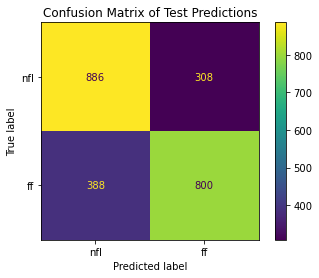

In [200]:
# Confusion matrix of the test data
metrics.plot_confusion_matrix(gs, X_test, y_test)
plt.title('Confusion Matrix of Test Predictions')
plt.yticks([0,1],['nfl', 'ff'])
plt.xticks([0,1],['nfl', 'ff']);

In [192]:
# Calculating Test Accuracy
(800 + 886)/ (800 + 886 + 388 + 308)

0.707808564231738

In [193]:
# Calculating Test Recall
800/(800 + 388)

0.6734006734006734

**Conclusions:** With an accuracy score of .71 and a recall of .67, this model greatly outperforms the baseline. If used to help target advertising, the advertisements would be expected to reach 67% of people interested in fantasy football while saving the company a large amount in advertising costs. I had hoped to optimize my recall a bit more to reduce the number of potential customers missed, but was unable to do so without badly hurting my accuracy. I am selecting this model because even though it has a slightly worse accuracy than the Random Forest, I value recall more in this application.

In [189]:
# Creating Dataframe of coefficients
coef_df = pd.DataFrame(gs.best_estimator_.named_steps['model'].coef_[0],
            index = gs.best_estimator_.named_steps['vect'].get_feature_names(), 
            columns = ['coef'])

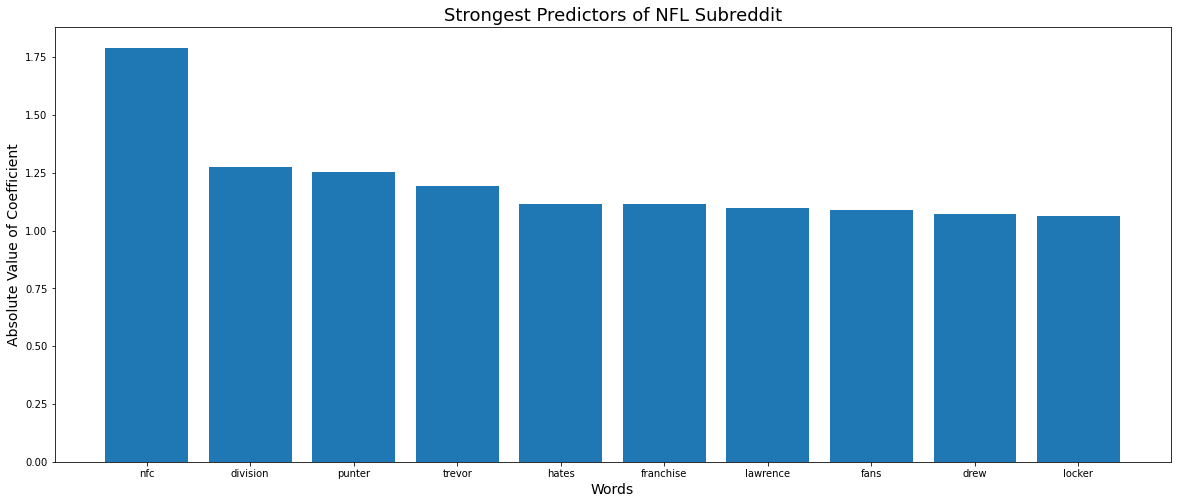

In [195]:
# Making a bar graph to see which words have the largest negative effect on the model
plt.figure(figsize = (20, 8))
plt.bar(coef_df.sort_values(by = 'coef', ascending = True).head(10).index,
       abs(coef_df.sort_values(by = 'coef', ascending = True).head(10)['coef']))
plt.title('Strongest Predictors of NFL Subreddit', fontsize = 18)
plt.xlabel('Words', fontsize = 14)
plt.ylabel('Absolute Value of Coefficient', fontsize = 14);

**Conclusions:** These are the words that the model has determined have the largest impact in the negative direction meaning they predict the nfl subreddit. Two words that jump out to me are trevor and lawrence. Trevor Lawrence was a college player at the time and was recently darafted 1st overall. It makes sense that football fans would care about him, but because he is not in the nfl, he is unimportant to fantasy football. The word punter also makes sense as fantasy teams do not have punters.

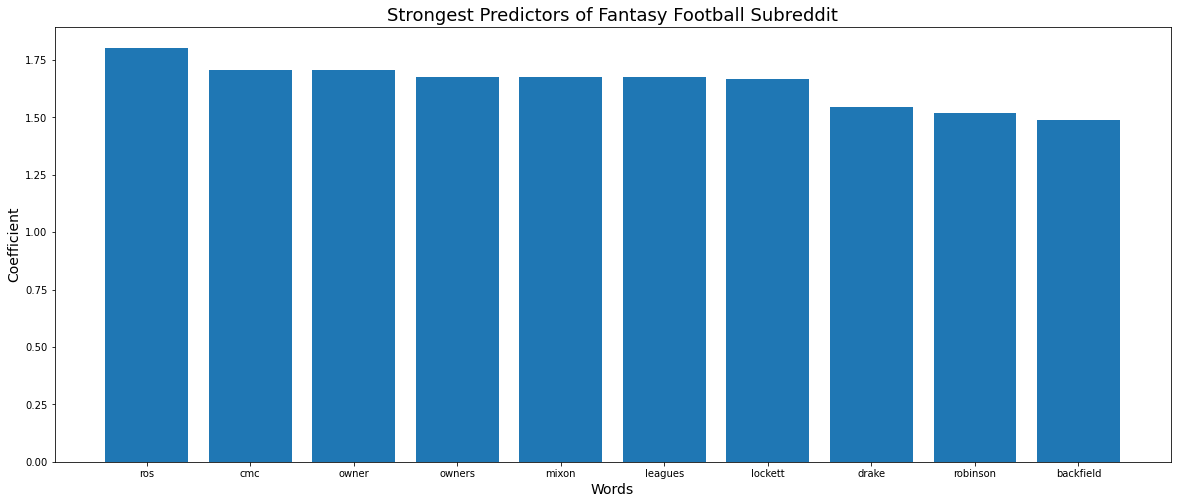

In [196]:
# Bar Graph to see which words have the strongest positive effect on the model
plt.figure(figsize = (20, 8))
plt.bar(coef_df.sort_values(by = 'coef', ascending = False).head(10).index,
       coef_df.sort_values(by = 'coef', ascending = False).head(10)['coef'])
plt.title('Strongest Predictors of Fantasy Football Subreddit', fontsize = 18)
plt.xlabel('Words', fontsize = 14)
plt.ylabel('Coefficient', fontsize = 14);

**Conclusions:** These are the words that have the largest effect in the positive direction meaning they predict the fantasy football subreddit. This list is mostly made up of high performing individual players. Whereas football fans tend to care about only their team, fantasy players are very interested in strong statistical performers. Two other words that jump out are ros and backfield. ROS means rest of schedule and is used as a metric when identifying a players value. A backfield is the running backs of a team. When evaluating running backs fantasy owners worry about "Crowded Backfields" meaning that the team has many running backs competing for points. 